## Modules

In [176]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from __future__ import print_function
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import pydot
import graphviz

## Global Variables

In [177]:
num_classes = 10
input_dim = 784

## Data import and preprocessing

All data is normalized and serialized into a vector.

In [178]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

In [179]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Train Neural Net to recognize MNIST digits

In [180]:
# constants
batch_size = 128
num_classes = 10
epochs = 20
hidden1_dim = 512
hidden2_dim = 512

In [181]:
model = Sequential()
model.add(Dense(hidden1_dim, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.2))
model.add(Dense(hidden2_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [182]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [183]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

### Train or load Model

In [184]:
model = keras.models.load_model('models/model.h5')
# model.fit(x_train, y_train, 
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_val, y_val))

Save trained model

In [185]:
# model.save('models/model.h5')

In [186]:
# plot_model(model, to_file='images/mnist_nn.png', show_shapes=True, show_layer_names=True, rankdir='LR')

![MNIST Neural Net](images/mnist_nn.png)

In [187]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.105847611373
Test accuracy: 0.9847


# Single layer autoencoder

## Model Definitions

Using keras module with compression to 32 floats.

In [188]:
######## constants for single autoencoder ############
encoding_dim = 36
epochs = 50
batch_size = 256

In [189]:
# input placeholder
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

single_autoencoder = Model(input_img, decoded)

Encoder Model:

In [190]:
# this model maps an input to its encoded representation
single_encoder = Model(input_img, encoded)

Decoder Model:

In [191]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = single_autoencoder.layers[-1]
# create the decoder model
single_decoder = Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

Binary Cross Entropy = Binomial Cross Entropy = Special Case of Multinomial Cross Entropy 

In [192]:
single_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [193]:
single_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 36)                28260     
_________________________________________________________________
dense_49 (Dense)             (None, 784)               29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


### Train or load single autoencoder model

In [194]:
single_autoencoder = keras.models.load_model('models/single_autoencoder.h5')
# single_autoencoder.fit(x_train, x_train, 
#                        epochs=epochs,
#                        batch_size=batch_size,
#                        shuffle=True,
# #                        validation_split = 0.2,
#                        validation_data=(x_val, x_val),
#                        callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

### Save Models

In [195]:
# single_autoencoder.save('models/single_autoencoder.h5')

In [196]:
score = single_autoencoder.evaluate(x_val, x_val, verbose=0)
print(score)

0.0980520643711


In [197]:
# plot_model(single_autoencoder, to_file='images/single_autoencoder.png', show_shapes=True, show_layer_names=True, rankdir='LR')

![single_autoencoder](images/single_autoencoder.png)

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about {{score}}. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [198]:
encoded_imgs = single_encoder.predict(x_val)
# decoded_imgs = single_decoder.predict(encoded_imgs)
decoded_imgs = single_autoencoder.predict(x_val)

In [199]:
single_encoder.predict(x_train)[0]

array([ 0.6961084 ,  0.        ,  0.77813607,  0.40176728,  0.        ,
        0.        ,  0.        ,  0.33431306,  0.04606917,  0.43634456,
        0.        ,  0.        ,  0.77997583,  0.07419071,  0.        ,
        0.        ,  0.        ,  0.08863272,  0.79129517,  0.        ,
        0.72704178,  0.        ,  0.        ,  0.47759071,  0.        ,
        0.        ,  0.61356646,  0.22224584,  0.        ,  0.        ,
        0.        ,  0.23768203,  0.20694038,  0.        ,  0.        ,  0.        ], dtype=float32)

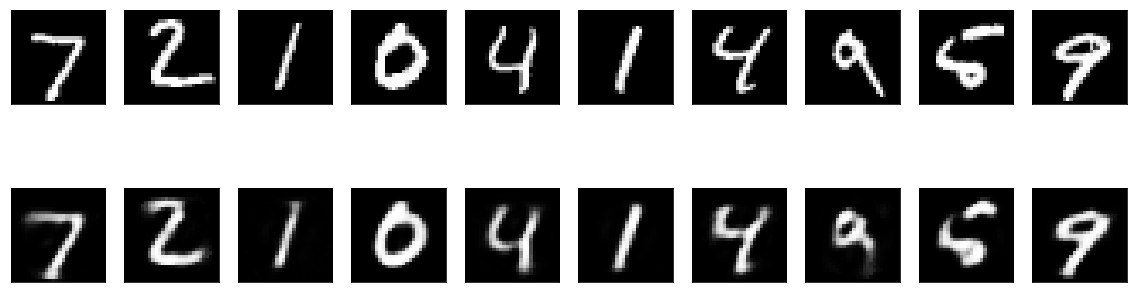

In [200]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The following code only works if the encoder is compiled during this session

## Visualization of the hidden layer - worth nothing

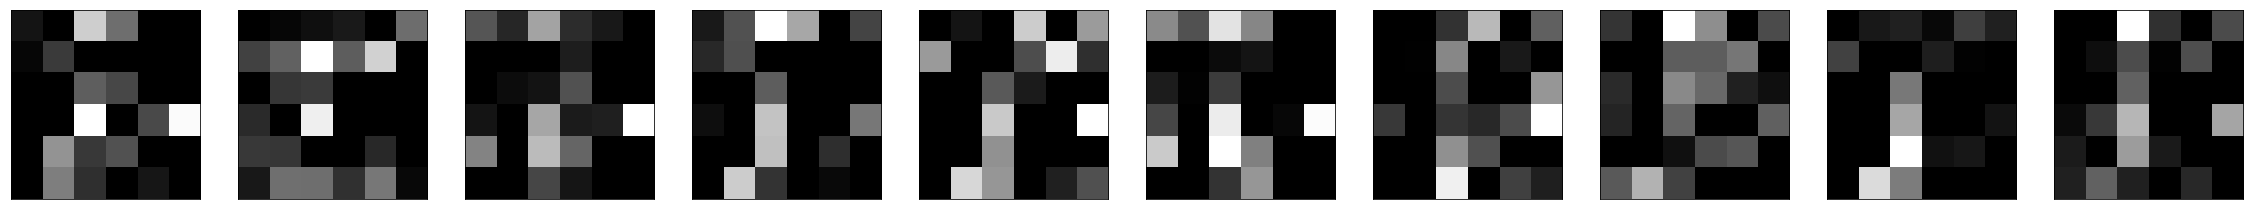

In [201]:
n = 10
plt.figure(figsize=(40, 10))
for i in range(n):  
    # display encoded
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(6, 6))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Test the Autoencoder with a simple Neural Net

In [202]:
single_ae_test_model = Sequential()
single_ae_test_model.add(Dense(16, activation='relu', input_shape=(36,)))
single_ae_test_model.add(Dropout(0.2))
single_ae_test_model.add(Dense(10, activation='softmax'))

In [203]:
single_ae_test_model.compile(loss='categorical_crossentropy',
                             optimizer=RMSprop(),
                             metrics=['accuracy'])

In [204]:
single_ae_test_model = keras.models.load_model('models/single_ae_test_model.h5')
# single_ae_test_model.fit(single_encoder.predict(x_train), y_train, 
#                          batch_size=batch_size,
#                          epochs=20,
#                          verbose=1,
#                          validation_data=(single_encoder.predict(x_val), y_val))

In [205]:
# single_ae_test_model.save('models/single_ae_test_model.h5')

In [206]:
score = single_ae_test_model.evaluate(single_encoder.predict(x_val), y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 5.11377786255
Test accuracy: 0.0943


# Stacked Autoencoder

In [207]:
######## constants for stacked autoencoder ############
encoding_dim1 = 128
encoding_dim2 = 64
encoding_dim3 = 32
decoding_dim1 = 64
decoding_dim2 = 128
decoding_dim3 = input_dim
epochs = 100
batch_size = 256

In [208]:
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim1, activation='relu')(input_img)
encoded = Dense(encoding_dim2, activation='relu')(encoded)
encoded = Dense(encoding_dim3, activation='relu')(encoded)

decoded = Dense(decoding_dim1, activation='relu')(encoded)
decoded = Dense(decoding_dim2, activation='relu')(decoded)
decoded = Dense(decoding_dim3, activation='sigmoid')(decoded)

In [209]:
stacked_autoencoder = Model(input_img, decoded)
stacked_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
stacked_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_55 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_56 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_57 (Dense)             (None, 784)               101136    
Total para

In [210]:
stacked_autoencoder = keras.models.load_model('models/stacked_autoencoder.h5')
# stacked_autoencoder.fit(x_train, x_train,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 validation_data=(x_val, x_val))

Save the model

In [211]:
# stacked_autoencoder.save('models/stacked_autoencoder.h5')

In [212]:
score = stacked_autoencoder.evaluate(x_val, x_val, verbose=0)
print(score)

0.11782884047


In [213]:
# plot_model(stacked_autoencoder, to_file='images/stacked_autoencoder.png', show_shapes=True, show_layer_names=True, rankdir='LR')

![stacked_autoencoder](images/stacked_autoencoder.png)

In [214]:
decoded_imgs = stacked_autoencoder.predict(x_val)

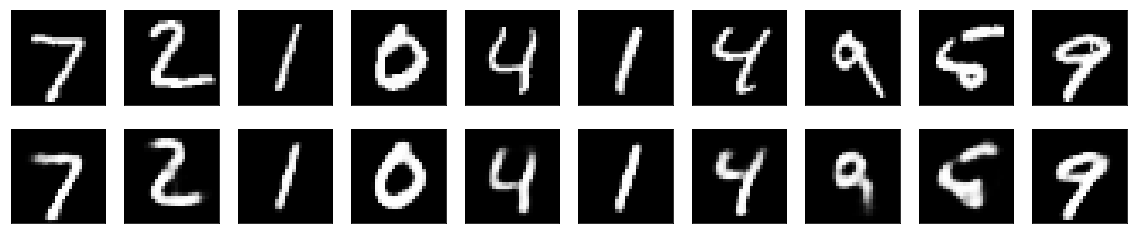

In [215]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Data

In [216]:
noise_factor = 0.5

In [217]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

# re-normalization by clipping to the intervall (0,1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

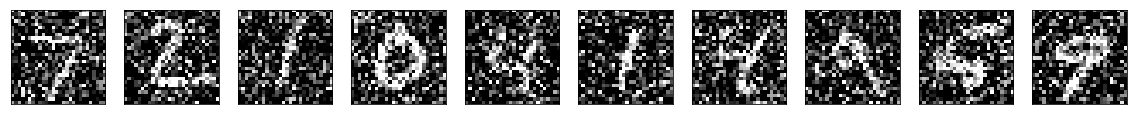

In [218]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_val_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Stick with the stack

In [219]:
denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
denoising_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_55 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_56 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_57 (Dense)             (None, 784)               101136    
Total para

### Train or load a stacked denoising autoencoder

In [220]:
denoising_autoencoder = keras.models.load_model('models/denoising_autoencoder.h5')
# denoising_autoencoder.fit(x_train_noisy, x_train,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 validation_data=(x_val_noisy, x_val),
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Save trained model

In [221]:
# denoising_autoencoder.save('models/denoising_autoencoder.h5')

In [222]:
decoded_imgs = denoising_autoencoder.predict(x_val_noisy)

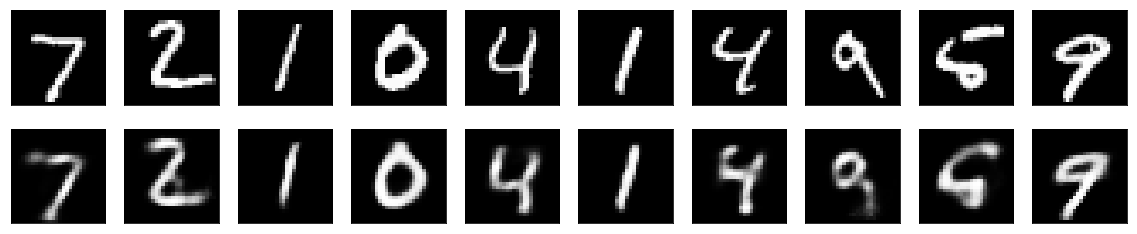

In [223]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Compare results

## Classification of noisy data

In [224]:
score = model.evaluate(x_val_noisy, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 9.13666110077
Test accuracy: 0.3839


## Classification of denoised data

In [225]:
score = model.evaluate(decoded_imgs, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.396575538995
Test accuracy: 0.9386


# Additional Information and Footage

## Cross Entropy

![Cross Entropy](images\2017-12-03 10_42_19-Machine Learning_ Should I use a categorical cross entropy or binary cross entro.png)

## Batch Size

Batch size defines number of samples that going to be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up batch_size equal to 100. Algorithm takes first 100 samples (from 1st to 100th) from the training dataset and trains network. Next it takes second 100 samples (from 101st to 200th) and train network again. We can keep doing this procedure until we will propagate through the networks all samples. The problem usually happens with the last set of samples. In our example we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get final 50 samples and train the network.

Advantages:

* It requires less memory. Since you train network using less number of samples the overall training procedure requires less memory. It's especially important in case if you are not able to fit dataset in memory.
* Typically networks trains faster with mini-batches. That's because we update weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages:

* The smaller the batch the less accurate estimate of the gradient. In the figure below you can see that mini-batch (green color) gradient's direction fluctuates compare to the full batch (blue color).

![https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network](images\lU3sx.png)

to be done:
- check various encoders with different numbers of hidden layers
- feature extraction

# Dropout

Deep neural nets with a large number of parameters are very powerful machine learning
systems. However, overfitting is a serious problem in such networks. Large networks are also
slow to use, making it difficult to deal with overfitting by combining the predictions of many
different large neural nets at test time. Dropout is a technique for addressing this problem.
The key idea is to randomly drop units (along with their connections) from the neural
network during training. This prevents units from co-adapting too much. During training,
dropout samples from an exponential number of different “thinned” networks. At test time,
it is easy to approximate the effect of averaging the predictions of all these thinned networks
by simply using a single unthinned network that has smaller weights. This significantly
reduces overfitting and gives major improvements over other regularization methods. We
show that dropout improves the performance of neural networks on supervised learning
tasks in vision, speech recognition, document classification and computational biology,
obtaining state-of-the-art results on many benchmark data sets.

For more information on dropout visit http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf